# CRORIS projects graph

In [2]:
### IMPORTS ###
#!pip install pandas
import pandas as pd
#!pip install networkx
import networkx as nx
#!pip install matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#!pip install python-louvain
from community import community_louvain
#!pip install nxviz
import nxviz as nv
from nxviz import annotate
import time
import numpy as np
import statistics

drive_path = 'data2/'

In [3]:
### FUNCTIONS ###
# conversion from HRK to EUR
def currency_conversion(df):
    for index, row in df.iterrows():
        if row['currencyCode'] == 'HRK':
            df.at[index, 'totalCost'] = row['totalCost']/7.5
            df.at[index, 'currencyCode'] = 'EUR'
    return df

def ecdf(data):
    return np.sort(data), np.arange(1, len(data) + 1) / len(data)

def ecdf_degree_centrality(G):
    """ECDF of degree centrality."""
    med = statistics.median(list(nx.degree_centrality(G).values()))
    mid = 0.5
    x, y = ecdf(list(nx.degree_centrality(G).values()))
    plt.scatter(x, y)
    plt.xlabel("degree centrality")
    plt.ylabel("cumulative fraction")
    plt.vlines(med, 0, mid, linestyles='dashed', colors='red')
    plt.hlines(mid, 0, med, linestyles='dashed', colors='red')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)
    
def ecdf_betweenness_centrality(G):
    """ECDF of betweenness centrality."""
    med = statistics.median(list(nx.betweenness_centrality(G, weight='weight_inv').values()))
    mid = 0.5
    x, y = ecdf(list(nx.betweenness_centrality(G, weight=None).values()))
    plt.scatter(x, y)
    plt.xlabel("betweenness centrality")
    plt.ylabel("cumulative fraction")
    plt.vlines(med, 0, mid, linestyles='dashed', colors='red')
    plt.hlines(mid, 0, med, linestyles='dashed', colors='red')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)

def ecdf_degree(G):
    """ECDF of degree."""
    med = statistics.median([len(list(G.neighbors(n))) for n in G.nodes()])
    mid = 0.5
    num_neighbors = [len(list(G.neighbors(n))) for n in G.nodes()]
    x, y = ecdf(num_neighbors)
    plt.scatter(x, y)
    plt.xlabel("degree")
    plt.ylabel("cumulative fraction")
    plt.vlines(med, 0, mid, linestyles='dashed', colors='red')
    plt.hlines(mid, 0, med, linestyles='dashed', colors='red')
    plt.xlim(xmin=0)
    plt.ylim(ymin=0)

def circos_plot(G):
    """Draw a Circos Plot of the graph."""
    nv.circos(G)
    
'''source https://glowingpython.blogspot.com/2012/11/first-steps-with-networx.html?m=1'''
def trim_nodes(G,d):
    """ returns a copy of G without 
     the nodes with a degree less than d """
    Gt = G.copy()
    dn = nx.degree(Gt)

    remove = [node for node,degree in dict(Gt.degree()).items() if dn[node] <= d]

    Gt.remove_nodes_from(remove)
    return Gt

def weighted_degree(G, weight):
    result = dict()
    for node in G.nodes():
        weight_degree = 0
        for n in G.edges([node], data=True):
            weight_degree += n[2]['weight']
        result[node] = weight_degree
    return result

In [4]:
### CREATE PANDAS DFs ###
df_ustanova = pd.read_csv(drive_path+'CRORIS_df_ustanova.csv', index_col=0) 
df_osoba = pd.read_csv(drive_path+'CRORIS_df_osoba.csv', index_col=0) 
df_projekt = pd.read_csv(drive_path+'CRORIS_df_projekt.csv', index_col=0) 
df_financijer = pd.read_csv(drive_path+'CRORIS_df_financijer.csv', index_col=0) 
df_osoba_projekt = pd.read_csv(drive_path+'CRORIS_df_osoba_projekt.csv', index_col=0) 
df_projekt_financijer = pd.read_csv(drive_path+'CRORIS_df_projekt_financijer.csv', index_col=0) 
df_projekt_tip = pd.read_csv(drive_path+'CRORIS_df_projekt_tip.csv', index_col=0) 
df_projekt_ustanova = pd.read_csv(drive_path+'CRORIS_df_projekt_ustanova.csv', index_col=0)

## Creation of the Individuals Graph

In [5]:
### prepare the data for the creation of a graph, self-join to create edges df
dfo = pd.DataFrame()
df_osoba['osoba'] = df_osoba['ime'] + ' ' + df_osoba['prezime']
dfo = df_osoba_projekt.merge(df_osoba, left_on='osoba_id', right_on='id', suffixes=('_l', '_r'))
dfo = dfo.drop(['created_l', 'id', 'osobaPoirotId', 'ime', 'prezime', 'created_r'], axis=1)
dfo = dfo.merge(right=dfo, how='left', on='projekt_id')
dfo = dfo[dfo['osoba_id_x'] != dfo['osoba_id_y']] # remove selfloops
dfo = dfo.merge(df_projekt, left_on='projekt_id', right_on='id', suffixes=('_l', '_r'))
dfo = dfo.drop(['created', 'id', 'projektPoirotId', 'hrSifraProjekta'], axis=1)
#dfo = dfo[dfo['tipProjekta_id'] == 385] ### 385 represents science projects
dfo = currency_conversion(dfo)

In [6]:
# first we are creating multigraph and manually transverse the data set in df
Go = nx.MultiGraph()
len_dfo = len(dfo)
n=0 # counter za progress

for i, r in df_osoba.iterrows():
    Go.add_node(r[0], osoba = r[6])

for i, r in dfo.iterrows():
    n += 1 # counter za progress
    Go.add_edge(r[0], r[7], projekt = r[1], projektNaziv = r[19], pocetak = r[15], kraj = r[16], cost = r[18])
    
    progress = '{0:.3g}'.format((n/len_dfo)*100)
    #print(str(progress)+'% - Index: '+str(i)+'; U: '+str(r[0])+'; V: '+str(r[7])+'; Projekt: '+str(r[1]))

print('finished')
# backup in GEXF file
timestr = time.strftime("%Y%m%d-%H%M%S")
nx.write_gexf(Go, drive_path+'MultiGraph_Individuals_Export_'+timestr+'.gexf')

finished


In [7]:
# create weighted graph from M while merging edges (projects) down
M = Go
Go = nx.Graph()
for i, r in df_osoba.iterrows():
    Go.add_node(r[0], osoba = r[6])
    
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if Go.has_edge(u,v):
        Go[u][v]['weight'] += w
    else:
        Go.add_edge(u, v, weight=w)
        
Go = trim_nodes(Go,0)

## Creation of the Institutions Graph

In [8]:
# Creation of a df with source - target institution graph with projects as edges ready data
df = pd.DataFrame()
df = df_projekt_ustanova.merge(df_ustanova, left_on='ustanova_id', right_on='id', suffixes=('_l', '_r'))
df = df.merge(right=df, how='left', on='projekt_id') # triplikat!!!!!!!!
df = df.merge(df_projekt, left_on='projekt_id', right_on='id', suffixes=('_l', '_r'))
df = df[df['tipProjekta_id'] == 385]
df = df[df['ustanova_id_x'] != df['ustanova_id_y']] # remove selfloops
df = currency_conversion(df)
df = df[['projekt_id', 'ustanova_id_x', 'ustanovaNaziv_x', 'ustanova_id_y', 'ustanovaNaziv_y', 'acro', 'title', 'pocetak', 'kraj', 'currencyCode', 'totalCost', 'tipProjekta_id']]

In [9]:
# first we are creating multigraph and manually transverse the data set in df
G = nx.MultiGraph()
len_df = len(df)
n=0 # counter za progress

for i, r in df_ustanova.iterrows():
    G.add_node(r[0], ustanova = r[2])

for i, r in df.iterrows():
    n += 1 # counter za progress
    G.add_edge(r[1], r[3], projekt = r[0], projektNaziv = r[6], pocetak = r[7], kraj = r[8], cost = r[10])
    
    progress = '{0:.3g}'.format((n/len_df)*100)
    #print(str(progress)+'% - Index: '+str(i)+'; U: '+str(r[1])+'; V: '+str(r[3])+'; Projekt: '+str(r[0]))

print('finished')
# backup in GEXF file
timestr = time.strftime("%Y%m%d-%H%M%S")
nx.write_gexf(G, drive_path+'MultiGraph_Export_'+timestr+'.gexf')

finished


In [10]:
# reuse the saved graph
#G = nx.read_gexf('MultiGraph_Export.gexf')

In [11]:
# create weighted graph from M while merging edges (projects) down
M = G
G = nx.Graph()
for i, r in df_ustanova.iterrows():
    G.add_node(r[0], ustanova = r[2])
    
for u,v,data in M.edges(data=True):
    w = data['weight'] if 'weight' in data else 1.0
    if G.has_edge(u,v):
        G[u][v]['weight'] += w
    else:
        G.add_edge(u, v, weight=w)
        
G = trim_nodes(G,0)

## About the Individuals Graph

In [12]:
# check the size
print('No. of nodes: ', Go.order())
print('No. of edges: ', Go.size())

No. of nodes:  8284
No. of edges:  65879


In [13]:
# How many edges are present in the network as compared to the total possible number of edges
density = nx.density(Go)
print('The edge density is: ' + str(density))

The edge density is: 0.0019202122782008934


In [14]:
degree = Go.degree()
degree_sequence = sorted((d for n, d in degree), reverse=True)
degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)

print('The average degree is: ' + str(av_degree))

The average degree is: 15.905118300338001


## About the Institutions Graph

In [15]:
# check the size
print('No. of nodes: ', G.order())
print('No. of edges: ', G.size())

No. of nodes:  147
No. of edges:  627


In [16]:
# How many edges are present in the network as compared to the total possible number of edges
density = nx.density(G)
print('The edge density is: ' + str(density))

The edge density is: 0.05842885099245178


In [17]:
degree = G.degree()
degree_sequence = sorted((d for n, d in degree), reverse=True)
degree_list = []

for (n,d) in degree:
    degree_list.append(d)

av_degree = sum(degree_list) / len(degree_list)

print('The average degree is: ' + str(av_degree))

The average degree is: 8.53061224489796


# Plot Empirical Distribution Functions for Individuals

Graph desc: x is an observable
y represents cumulative fraction of data points smaller than a given value
top right 100% of data points are smaller than 

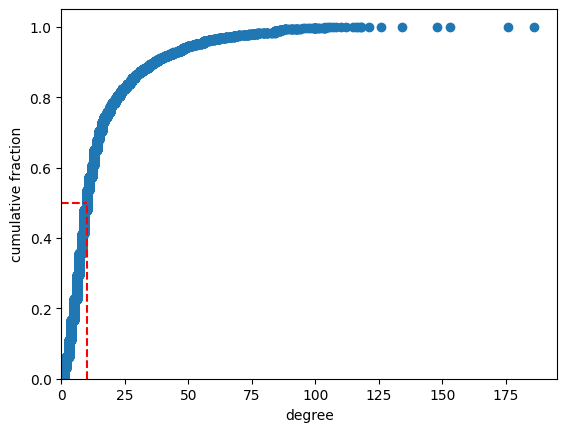

In [18]:
ecdf_degree(Go)

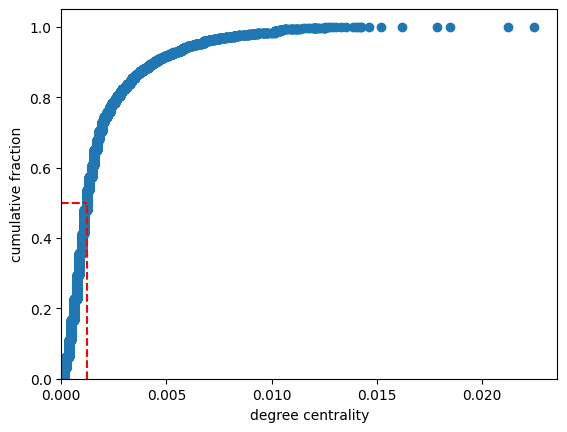

In [19]:
ecdf_degree_centrality(Go)

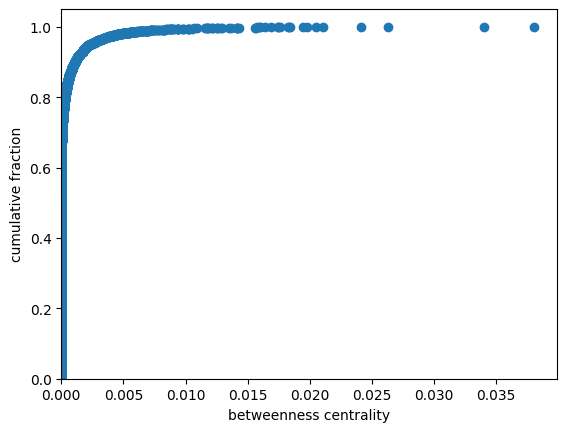

In [20]:
ecdf_betweenness_centrality(Go)

# Draw Circos plots for Individuals

In [21]:
# add degree property for each node
for n, d in Go.nodes(data=True):
    Go.nodes[n]["degree"] = Go.degree(n)

# add weight inverted for each edge
for u, v, d in Go.edges(data=True):
    Go.edges[u,v]["weight_inv"] = 1 / Go.edges[u,v]["weight"]

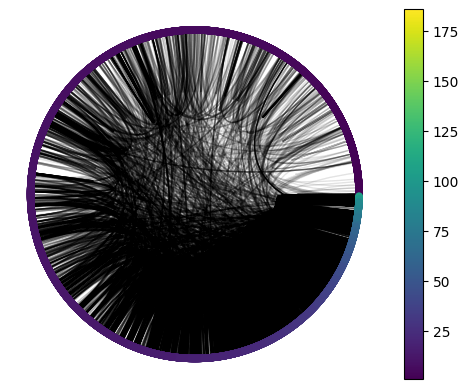

In [22]:
nv.circos(Go, sort_by="degree", node_color_by="degree", edge_alpha_by="weight", node_enc_kwargs={"size_scale": 60})
annotate.node_colormapping(Go, color_by="degree")

# Plot Empirical Distribution Functions for Institutions

Graph desc: x is an observable
y represents cumulative fraction of data points smaller than a given value
top right 100% of data points are smaller than 

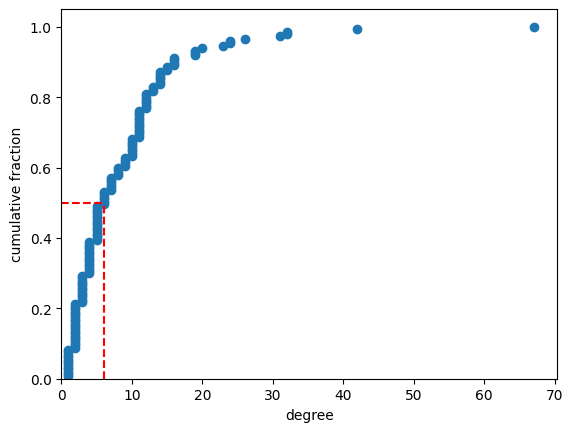

In [23]:
ecdf_degree(G)

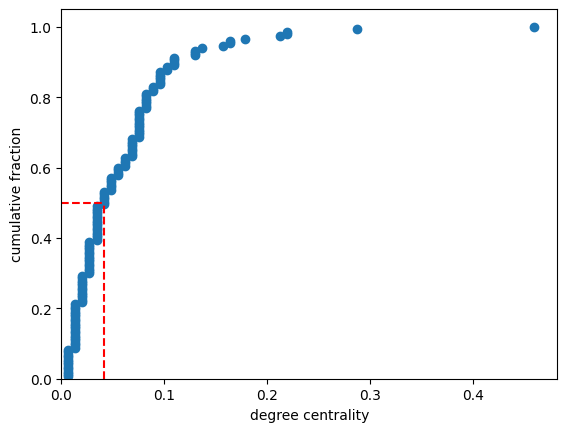

In [24]:
ecdf_degree_centrality(G)

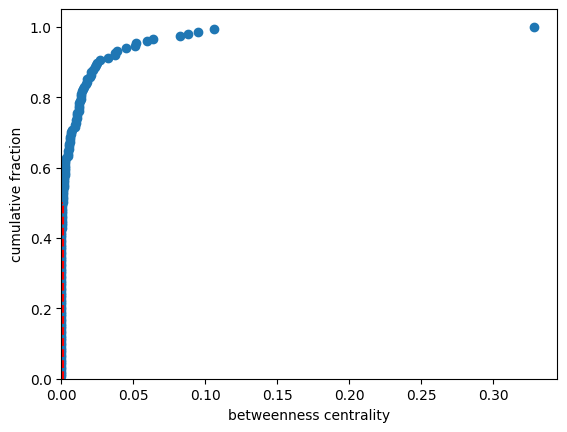

In [25]:
ecdf_betweenness_centrality(G)

# Draw Circos plots for Institutions

In [26]:
# add degree property for each node
for n, d in G.nodes(data=True):
    G.nodes[n]["degree"] = G.degree(n)

# add weight inverted for each edge
for u, v, d in G.edges(data=True):
    G.edges[u,v]["weight_inv"] = 1 / G.edges[u,v]["weight"]

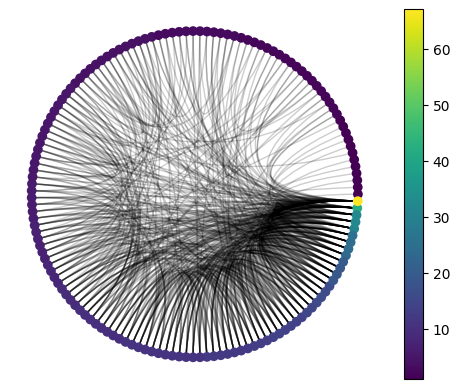

In [27]:
nv.circos(G, sort_by="degree", node_color_by="degree", node_enc_kwargs={"size_scale": 1.4})
annotate.node_colormapping(G, color_by="degree")

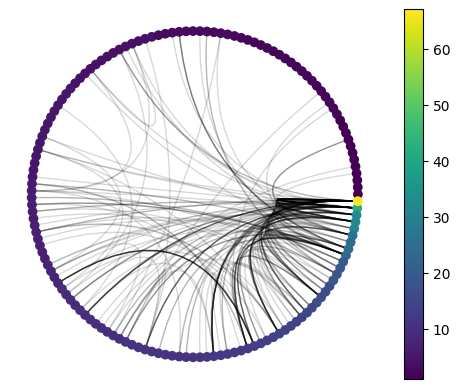

In [28]:
nv.circos(G, sort_by="degree", node_color_by="degree", edge_alpha_by="weight", node_enc_kwargs={"size_scale": 1.4})
annotate.node_colormapping(G, color_by="degree")

## Key Graph Parameters for Individuals

In [32]:
### Degree
df_D = pd.DataFrame(sorted(nx.degree(Go),
       key=lambda x:x[1], reverse=True), columns=['id', 'degree'])

### Weighted degree is calculated by summing the weight of all the edges of a node
df_Dw = pd.DataFrame(sorted(weighted_degree(Go,'weight').items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'weighted_degree'])

### Betweeness centrality finds nodes which are structurally important to the network, nodes which bind the network together and densely.
df_BC = pd.DataFrame(sorted(nx.betweenness_centrality(Go).items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'betweenness_centrality'])

df_BCw = pd.DataFrame(sorted(nx.betweenness_centrality(Go, weight='weight_inv').items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'betweenness_centrality_w'])

### Degree Centrality - The degree centrality for a node v is the fraction of nodes it is connected to.
df_DC = pd.DataFrame(sorted(nx.degree_centrality(Go).items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'degree_centrality'])

### Closeness Centrality
df_CC = pd.DataFrame(sorted(nx.closeness_centrality(Go).items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'closeness_centrality'])

### Page Rank # weight=None to find the unweighted results
df_PR = pd.DataFrame(sorted(nx.pagerank(Go, weight=None).items(),
        key=lambda x:x[1], reverse=True), columns=['id', 'pagerank'])

df_PRw = pd.DataFrame(sorted(nx.pagerank(Go, weight='weight').items(),
        key=lambda x:x[1], reverse=True), columns=['id', 'pagerank_w'])

### Eigenvector centrality decides that a node is important if it is connected to other important nodes. 
df_EC = pd.DataFrame(sorted(nx.eigenvector_centrality(Go).items(),
       key=lambda x:x[1], reverse=True), columns=['id', 'eigenvector_centrality'])

In [33]:
v.columns

Index(['id'], dtype='object')

In [34]:
### Replace ids of individual with their full names
m = df_osoba.set_index('id')['osoba'].to_dict()

df_D_n = df_D
v = df_D_n.filter(like='id')
df_D_n[v.columns] = v.replace(m)

df_Dw_n = df_Dw
v = df_Dw_n.filter(like='id')
df_Dw_n[v.columns] = v.replace(m)

df_BC_n = df_BC
v = df_BC_n.filter(like='id')
df_BC_n[v.columns] = v.replace(m)

df_BCw_n = df_BCw
v = df_BCw_n.filter(like='id')
df_BCw_n[v.columns] = v.replace(m)

df_DC_n = df_DC
v = df_DC_n.filter(like='id')
df_DC_n[v.columns] = v.replace(m)

df_CC_n = df_CC
v = df_CC_n.filter(like='id')
df_CC_n[v.columns] = v.replace(m)

df_PR_n = df_PR
v = df_PR_n.filter(like='id')
df_PR_n[v.columns] = v.replace(m)

df_PRw_n = df_PRw
v = df_PRw_n.filter(like='id')
df_PRw_n[v.columns] = v.replace(m)

In [35]:
### combine results in one df and save to a .csv file
table_size = 30000

results = pd.concat([df_D, df_Dw, df_BC, df_BCw, df_DC, df_CC, df_PR, df_PRw], axis=1)
results = results[0:table_size]
results.set_axis(['Individual', 'degree',
                  'Individual', 'weighted_degree',
                  'Individual', 'betweenness_centrality',
                  'Individual', 'betweenness_centrality_W', 
                  'Individual', 'degree_centrality',
                  'Individual', 'closeness_centrality', 
                  'Individual', 'page_rank', 
                  'Individual', 'page_rank_W'
                 ], axis='columns', inplace=True)
results.to_csv(drive_path+'results_individuals_'+timestr+'.csv')

In [36]:
### combine results in one df and save to a .csv file
table_size = 30000

results_n = pd.concat([df_D_n, df_Dw_n, df_BC_n, df_BCw_n, df_DC_n, df_CC_n, df_PR_n, df_PRw_n], axis=1)
results_n = results_n[0:table_size]
results_n.set_axis(['Individual', 'degree',
                  'Individual', 'weighted_degree',
                  'Individual', 'betweenness_centrality',
                  'Individual', 'betweenness_centrality_W', 
                  'Individual', 'degree_centrality',
                  'Individual', 'closeness_centrality', 
                  'Individual', 'page_rank', 
                  'Individual', 'page_rank_W'
                 ], axis='columns', inplace=True)
results_n.to_csv(drive_path+'results_individuals_names_'+timestr+'.csv')

In [37]:
# IOR 1, KRS 64, MEDILS 199
# unist [185, 189, 308, 16, 178, 166, 10, 316, 61, 21, 114, 172, 41, 144, 145, 287]
ustanova_list = [185, 189, 308, 16, 178, 166, 10, 316, 61, 21, 114, 172, 41, 144, 145, 287]
#osoba_list = [10389]

tmp = df_BC.merge(df_osoba, left_on=df_BC[0], right_on='id', suffixes=('_l', '_r'))
tmp 

KeyError: 0

In [38]:
results

,Individual,degree,Individual,weighted_degree,Individual,betweenness_centrality,Individual,betweenness_centrality_W,Individual,degree_centrality,Individual,closeness_centrality,Individual,page_rank,Individual,page_rank_W
0,Marijana Butorac,186,Mile Dželalija,396.0,Mile Dželalija,0.038007,Mile Dželalija,0.048464,Marijana Butorac,0.022456,Mile Dželalija,0.247327,Mile Dželalija,0.000661,Mile Dželalija,0.000662
1,Mile Dželalija,176,Marijana Butorac,390.0,Krešimir Pavelić,0.033993,Krešimir Pavelić,0.034885,Mile Dželalija,0.021248,Ivica Aviani,0.242434,Maja Abram,0.000554,Stipan Jonjić,0.000639
2,Zdeslav Jurić,153,Stipan Jonjić,386.0,Marijana Butorac,0.026268,Ivana Krpan,0.033746,Zdeslav Jurić,0.018472,Marijana Butorac,0.237256,Stipan Jonjić,0.000553,Ivica Aviani,0.000571
3,Ivica Aviani,148,Zdeslav Jurić,370.0,Sandra Kraljević Pavelić,0.024089,Ivica Aviani,0.033049,Ivica Aviani,0.017868,Sanja Rukavina,0.236438,Ivica Aviani,0.000530,Zdeslav Jurić,0.000556
4,Vedrana Mikulić Crnković,134,Vedrana Mikulić Crnković,368.0,Ivica Aviani,0.021087,Vanja Radolić,0.032219,Vedrana Mikulić Crnković,0.016178,Vedrana Mikulić Crnković,0.236237,Marijana Butorac,0.000515,Josip Grgić,0.000552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8279,Manda Antunović,1,Manda Antunović,2.0,Dalibor Bukvić,0.000000,Dalibor Bukvić,0.000000,Manda Antunović,0.000121,Ivan Konstantinović,0.000121,Davor Bonefačić,0.000021,Davor Bonefačić,0.000021
8280,Đuro Senčić,1,Đuro Senčić,2.0,Tomislav Fačini,0.000000,Tomislav Fačini,0.000000,Đuro Senčić,0.000121,Hrvoje Skenderović,0.000121,Mira Ristić,0.000021,Ivan Supek,0.000021
8281,Ivan Kovač,1,Ivan Kovač,2.0,Berislav Šipuš,0.000000,Berislav Šipuš,0.000000,Ivan Kovač,0.000121,Ali Mardan Dezfouli,0.000121,Ivan Supek,0.000021,Mira Ristić,0.000021
8282,Viktor Popović,1,Viktor Popović,2.0,Lucija Šimičić,0.000000,Lucija Šimičić,0.000000,Viktor Popović,0.000121,Viktor Popović,0.000121,Ivana Marinović Terzić,0.000021,Ivana Marinović Terzić,0.000021


## Key Graph Parameters for Institutions

In [39]:
### Degree
df_D = pd.DataFrame(sorted(degree(G),
       key=lambda x:x[1], reverse=True))

### Weighted degree is calculated by summing the weight of all the edges of a node
df_Dw = pd.DataFrame(sorted(weighted_degree(G,'weight').items(),
       key=lambda x:x[1], reverse=True))

### Betweeness centrality finds nodes which are structurally important to the network, nodes which bind the network together and densely.
df_BC = pd.DataFrame(sorted(nx.betweenness_centrality(G).items(),
       key=lambda x:x[1], reverse=True))

df_BCw = pd.DataFrame(sorted(nx.betweenness_centrality(G, weight='weight_inv').items(),
       key=lambda x:x[1], reverse=True))

### Degree Centrality - The degree centrality for a node v is the fraction of nodes it is connected to.
df_DC = pd.DataFrame(sorted(nx.degree_centrality(G).items(),
       key=lambda x:x[1], reverse=True))

### Closeness Centrality
df_CC = pd.DataFrame(sorted(nx.closeness_centrality(G).items(),
       key=lambda x:x[1], reverse=True))

### Page Rank # weight=None to find the unweighted results
df_PR = pd.DataFrame(sorted(nx.pagerank(G, weight=None).items(),
        key=lambda x:x[1], reverse=True))

df_PRw = pd.DataFrame(sorted(nx.pagerank(G, weight='weight').items(),
        key=lambda x:x[1], reverse=True))

In [40]:
### combine results in one df and save to a .csv file
table_size = 30

results = pd.concat([df_D, df_Dw, df_BC, df_BCw, df_DC, df_CC, df_PR, df_PRw], axis=1)
results = results[0:table_size]
results.set_axis(['Institution', 'degree',
                  'Institution', 'weighted_degree',
                  'Institution', 'betweenness_centrality',
                  'Institution', 'betweenness_centrality_W', 
                  'Institution', 'degree_centrality',
                  'Institution', 'closeness_centrality', 
                  'Institution', 'page_rank', 
                  'Institution', 'page_rank_W'
                 ], axis='columns', inplace=True)
results.to_csv(drive_path+'results_institutions_'+timestr+'.csv')

In [41]:
results

,Institution,degree,Institution,weighted_degree,Institution,betweenness_centrality,Institution,betweenness_centrality_W,Institution,degree_centrality,Institution,closeness_centrality,Institution,page_rank,Institution,page_rank_W
0,66,67,66,262.0,66,0.327977,66,0.623832,66,0.458904,66,0.618644,66,0.046020,66,0.061339
1,79,42,79,178.0,34,0.106124,79,0.263859,79,0.287671,79,0.528986,79,0.028917,79,0.041213
2,34,32,115,120.0,79,0.094859,74,0.196079,34,0.219178,115,0.508711,34,0.023224,115,0.028532
3,115,32,34,108.0,74,0.087945,34,0.183425,115,0.219178,34,0.503448,115,0.022891,34,0.027096
4,259,31,74,100.0,115,0.082524,115,0.096316,259,0.212329,259,0.500000,259,0.020557,74,0.026797
5,45,26,45,84.0,259,0.063984,75,0.082481,45,0.178082,114,0.485050,74,0.019231,45,0.020232
6,196,24,185,78.0,75,0.059404,185,0.076626,196,0.164384,45,0.483444,45,0.017849,185,0.019757
7,185,24,259,74.0,185,0.051847,148,0.061313,185,0.164384,196,0.481848,185,0.016650,259,0.018139
8,74,23,10,64.0,45,0.051439,282,0.053944,74,0.157534,185,0.475570,196,0.015900,8,0.015754
9,114,20,196,56.0,47,0.045124,45,0.053222,114,0.136986,74,0.469453,8,0.014920,10,0.015089


# Graph in time

In [42]:
### Create a list of graphs for each individual year in the dataset
df['pocetak'] = pd.to_datetime(df['pocetak'], errors='coerce')
df_graphs = [nx.from_pandas_edgelist(
        df[df['pocetak'].dt.to_period("Y")==str(i)],
        source='ustanova_id_x', target='ustanova_id_y')
        for i in range(1996, 2023)]

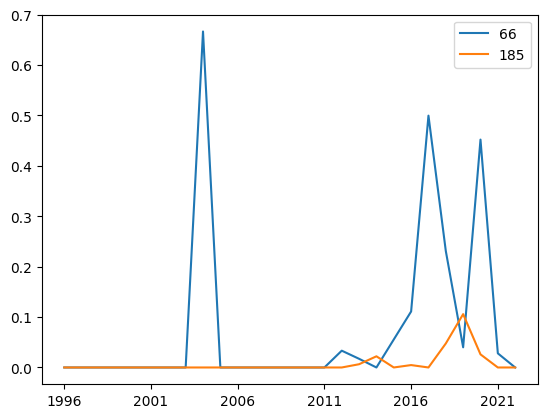

In [43]:
### print timeline chart of institution through years
dates = list(range(1996, 2023,5))
evol = [nx.betweenness_centrality(graph)
        for graph in df_graphs]
evol_df = pd.DataFrame.from_records(evol).fillna(0)
#evol_df = evol_df[0:25]
ax = evol_df[[66,185]].plot()
ax.xaxis.set_ticks(list(range(0,len(evol_df),5)))
ax.set_xticklabels(dates)
plt.show()

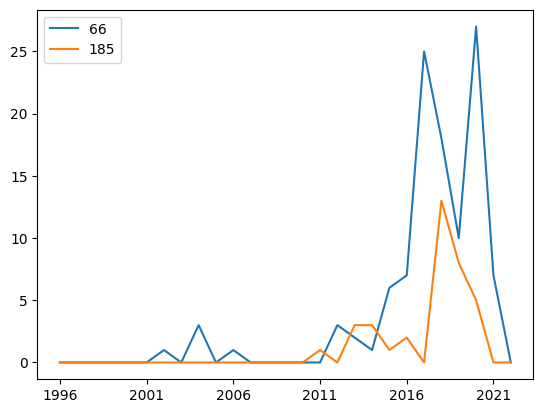

In [44]:
### print timeline chart of institution through years
dates = list(range(1996, 2023,5))
evol = [dict(graph.degree())
        for graph in df_graphs]
evol_df = pd.DataFrame.from_records(evol).fillna(0)
#evol_df = evol_df[0:26]
ax = evol_df[[66,185]].plot()
ax.xaxis.set_ticks(list(range(0,len(evol_df),5)))
ax.set_xticklabels(dates)
plt.show()

## Provjera

In [45]:
print(df.loc[df['projekt_id'] == 553])
list(df)

    projekt_id  ustanova_id_x             ustanovaNaziv_x  ustanova_id_y  \
87         553             66     Institut Ruđer Bošković             33   
88         553             66     Institut Ruđer Bošković             46   
89         553             33  Institut za fiziku, Zagreb             66   
91         553             33  Institut za fiziku, Zagreb             46   
92         553             46       Stomatološki fakultet             66   
93         553             46       Stomatološki fakultet             33   

               ustanovaNaziv_y acro  \
87  Institut za fiziku, Zagreb  NaN   
88       Stomatološki fakultet  NaN   
89     Institut Ruđer Bošković  NaN   
91       Stomatološki fakultet  NaN   
92     Institut Ruđer Bošković  NaN   
93  Institut za fiziku, Zagreb  NaN   

                                                title    pocetak        kraj  \
87  Prosudba novih bioaktivnih materijala i postup... 2012-03-01  2015-01-03   
88  Prosudba novih bioaktivnih ma

['projekt_id',
 'ustanova_id_x',
 'ustanovaNaziv_x',
 'ustanova_id_y',
 'ustanovaNaziv_y',
 'acro',
 'title',
 'pocetak',
 'kraj',
 'currencyCode',
 'totalCost',
 'tipProjekta_id']

In [46]:
pd.set_option('display.max_columns', None)
df[0:4]

,projekt_id,ustanova_id_x,ustanovaNaziv_x,ustanova_id_y,ustanovaNaziv_y,acro,title,pocetak,kraj,currencyCode,totalCost,tipProjekta_id
87,553,66,Institut Ruđer Bošković,33,"Institut za fiziku, Zagreb",NaN,Prosudba novih bioaktivnih materijala i postup...,2012-03-01,2015-01-03,EUR,177866.666667,385
88,553,66,Institut Ruđer Bošković,46,Stomatološki fakultet,NaN,Prosudba novih bioaktivnih materijala i postup...,2012-03-01,2015-01-03,EUR,177866.666667,385
89,553,33,"Institut za fiziku, Zagreb",66,Institut Ruđer Bošković,NaN,Prosudba novih bioaktivnih materijala i postup...,2012-03-01,2015-01-03,EUR,177866.666667,385
91,553,33,"Institut za fiziku, Zagreb",46,Stomatološki fakultet,NaN,Prosudba novih bioaktivnih materijala i postup...,2012-03-01,2015-01-03,EUR,177866.666667,385


In [ ]:
# TEST get weight of edge
G.edges[66,33]['weight_inv']
Go.nodes[3037]['degree']

9

In [ ]:
# MODULARITY
from networkx.algorithms.community.quality import modularity

# calculate modularity of the subgraph
modularity_value = modularity(G, [sampled_nodes])
print("Modularity of the subgraph: ", modularity_value)

https://www.datacamp.com/tutorial/social-network-analysis-python#!
cliques - https://predictivehacks.com/social-network-analysis-of-game-of-thrones/
textnets - https://www.jboy.space/blog/pandemic-side-projects.html